In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import pickle
from typing import List

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import mnist

import hmcalisterHopfieldUtils
from autoEncoder import AutoEncoder, AutoEncoderSigmoidCustomLoss, AutoEncoderTanhCustomLoss

2023-11-16 13:34:49.884569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 13:34:49.940195: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 13:34:50.959865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# TARGET_CLASSES = [0, 1]
TARGET_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
dataShape = x_test.shape[1:]

targetTrainMask = np.isin(y_train, TARGET_CLASSES)
x_train = x_train[targetTrainMask,:,:]
y_train = y_train[targetTrainMask]
targetTestMask = np.isin(y_test, TARGET_CLASSES)
x_test = x_test[targetTestMask,:,:]
y_test = y_test[targetTestMask]

In [11]:
def CreateAndTrainAutoencoder(encoderLossWeighting: float, 
                              latentDimension: int,
                              epochs: int=10,
                              hiddenLayerShapes: List[int] = [128,128,64],
                              encoderActivation:str = "sigmoid", 
                              loadModel: bool = False, 
                              savePath: str = "model.keras",
                              verbose=1):
    autoencoder = AutoEncoder(inputShape=dataShape, latentShape=latentDimension, hiddenLayerShapes=hiddenLayerShapes, encoderOutputActivationFunction=encoderActivation)
    autoencoder.summary()
    if not loadModel:
        if encoderActivation == "sigmoid":
            encoderLoss = AutoEncoderSigmoidCustomLoss()
        elif encoderActivation == "tanh":
            encoderLoss = AutoEncoderTanhCustomLoss()
        else:
            print("ERR: encoder activation must be sigmoid or tanh")
            exit(1)

        autoencoder.compile(optimizer='adam', loss={
            "decoderOutput": "mse",
            "encoderOutput": encoderLoss
        }, loss_weights=[1, encoderLossWeighting])
        modelHistory = autoencoder.fit(x_train, x_train,
                        epochs=epochs,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        verbose=verbose)
        with open("modelHistory", "wb") as f:
            pickle.dump(modelHistory.history, f)
        autoencoder.save_weights(savePath)
    else:
        autoencoder.load_weights(savePath)
    return autoencoder

In [12]:
LATENT_DIMENSION = 128
autoencoder = CreateAndTrainAutoencoder(0.05, latentDimension=LATENT_DIMENSION, 
                                        epochs=20, hiddenLayerShapes = [[128,64], []],)

Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (1, 128)                  117056    
                                                                 
 decoder (Sequential)        (1, 28, 28)               101136    
                                                                 
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2023-11-16 13:54:10.064779: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-11-16 13:54:10.195289: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 8s 4ms/step - loss: 0.0432 - decoderOutput_loss: 0.0417 - encoderOutput_loss: 0.0303 - val_loss: 0.0317 - val_decoderOutput_loss: 0.0300 - val_encoderOutput_loss: 0.0335
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0299 - decoderOutput_loss: 0.0278 - encoderOutput_loss: 0.0406 - val_loss: 0.0283 - val_decoderOutput_loss: 0.0261 - val_encoderOutput_loss: 0.0451
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0282 - decoderOutput_loss: 0.0258 - encoderOutput_loss: 0.0479 - val_loss: 0.0274 - val_decoderOutput_loss: 0.0249 - val_encoderOutput_loss: 0.0496
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0277 - decoderOutput_loss: 0.0252 - encoderOutput_loss: 0.0500 - val_loss: 0.0271 - val_decoderOutput_loss: 0.0245 - val_encoderOutput_loss: 0.0510
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0271 - decoderOutput_loss: 0.

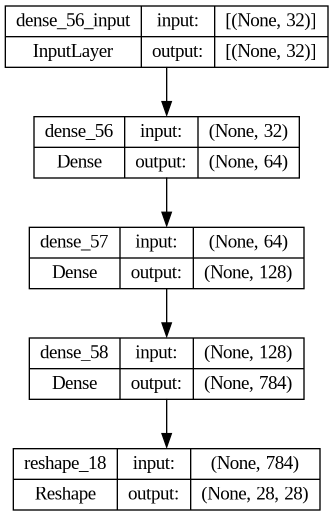

In [78]:
# tf.keras.utils.plot_model(autoencoder.encoderNetwork, show_shapes=True)
# tf.keras.utils.plot_model(autoencoder.decoderNetwork, show_shapes=True)


In [13]:
encodedVectors = autoencoder.encoderNetwork(x_test).numpy()
decodedImages = autoencoder.decoderNetwork(encodedVectors).numpy()

binaryHeaviside = hmcalisterHopfieldUtils.hopfield.binaryHeaviside
bipolarHeaviside = hmcalisterHopfieldUtils.hopfield.bipolarHeaviside
heavisideVectors = binaryHeaviside(encodedVectors-0.5)
heavisideDecodedImages = autoencoder.decoderNetwork(heavisideVectors).numpy()

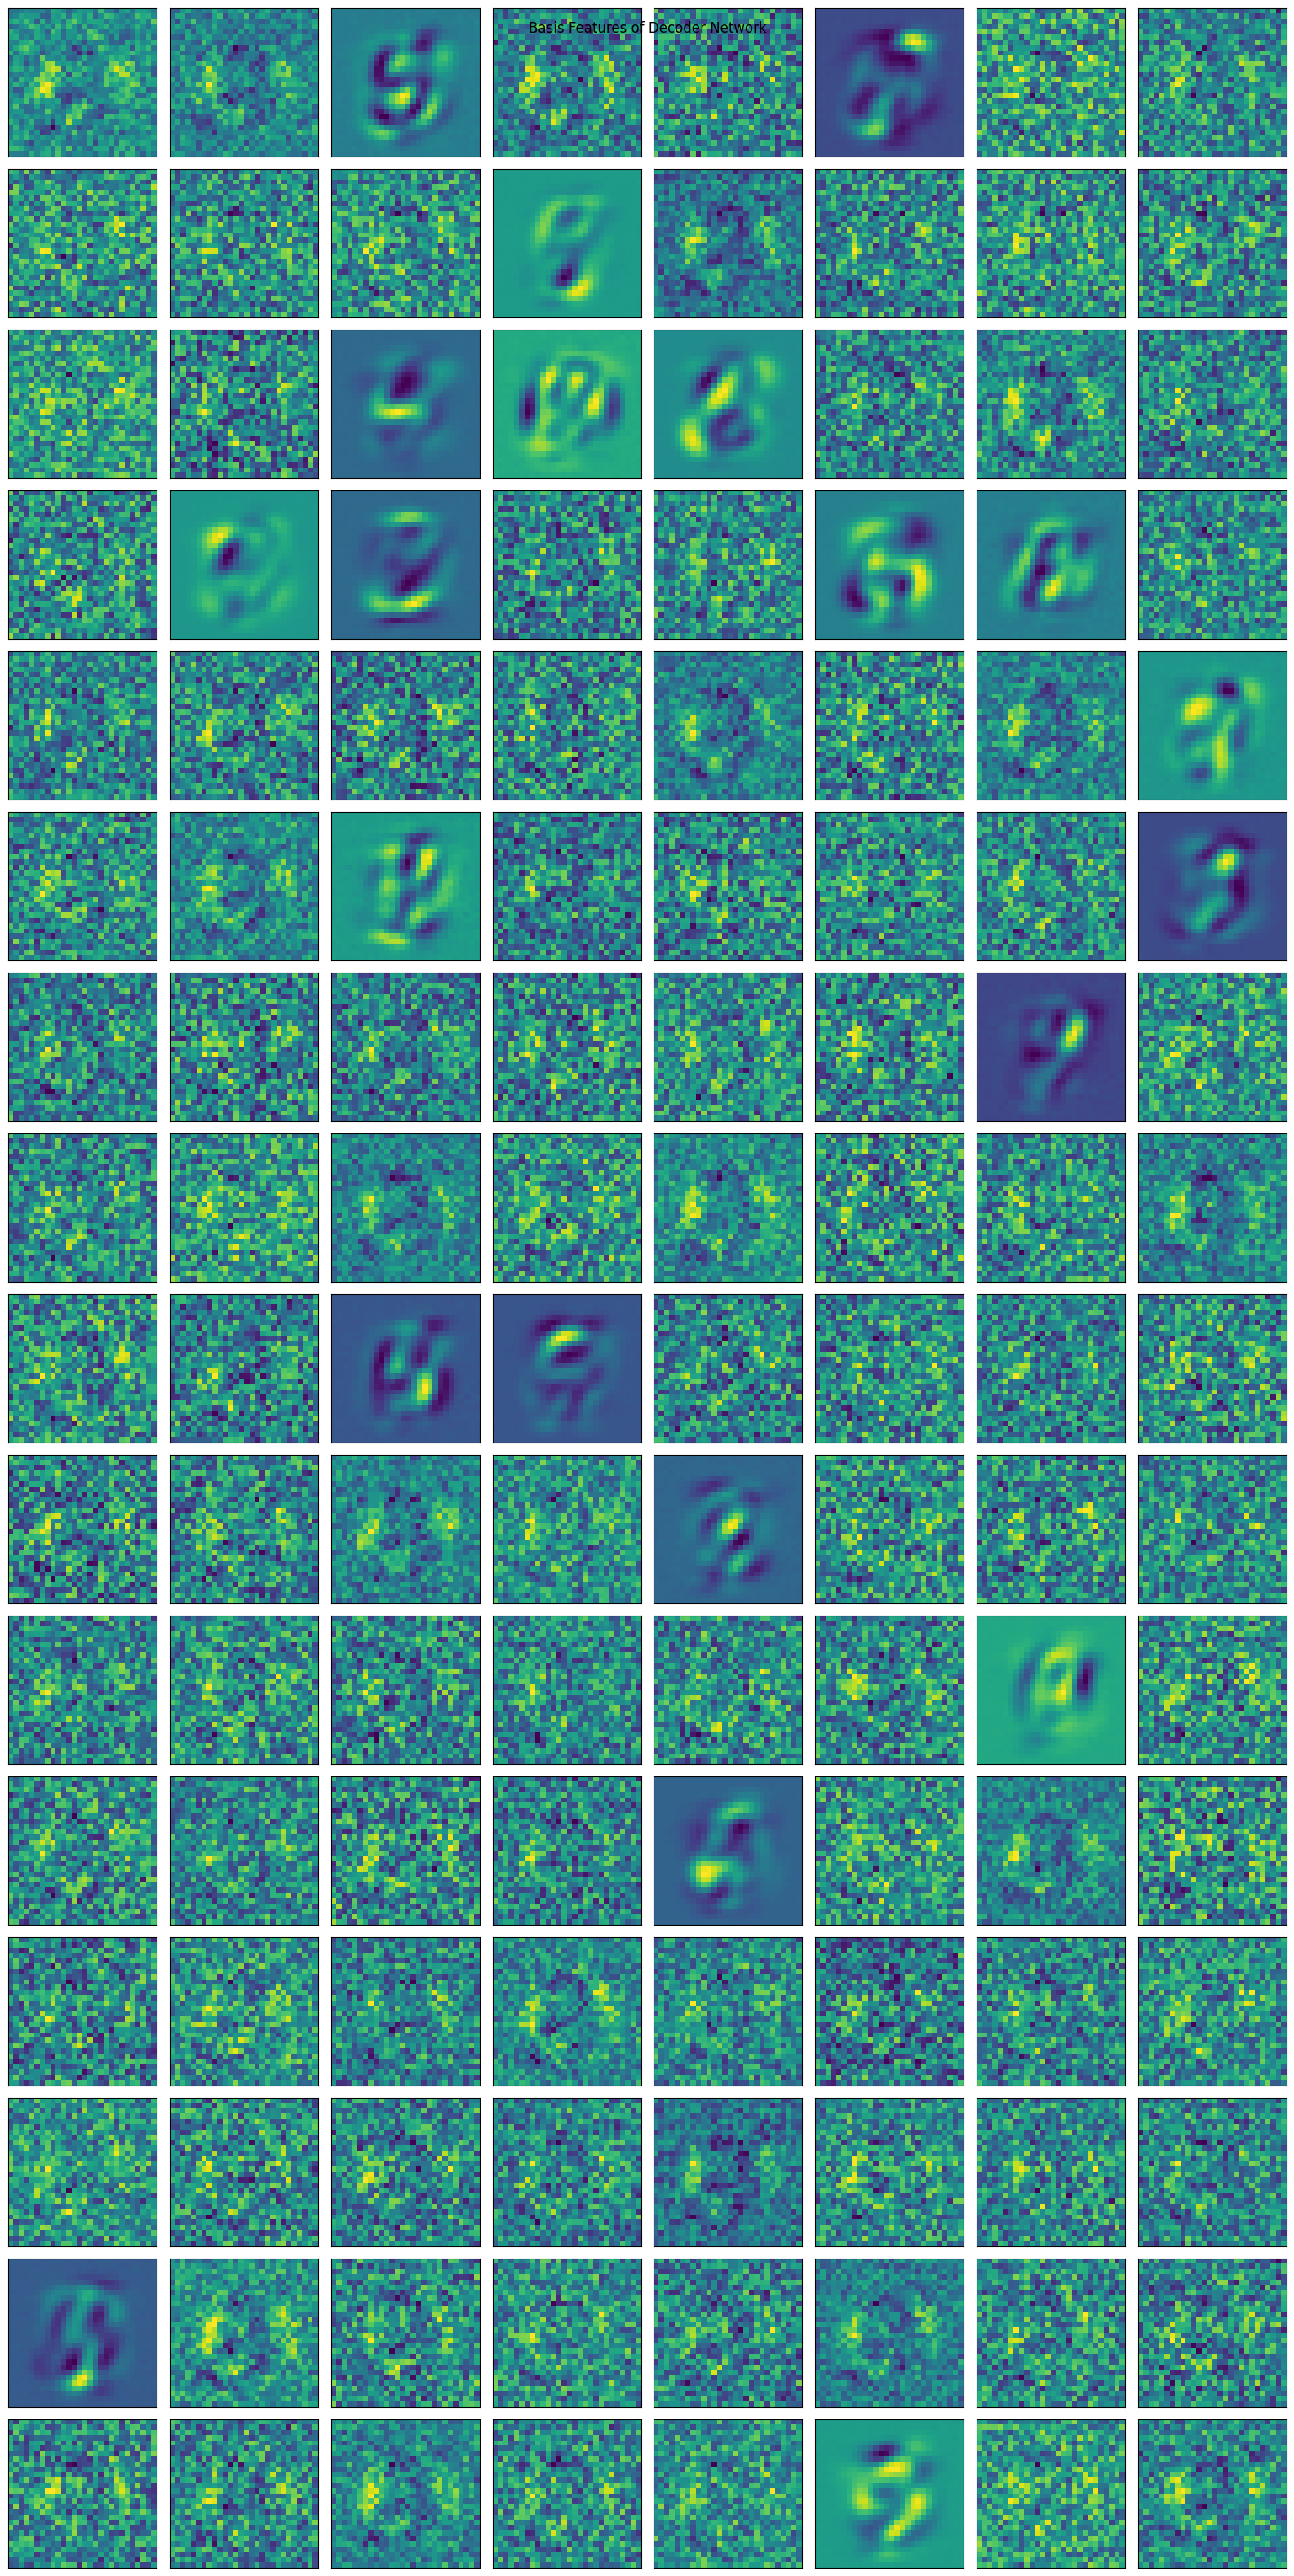

In [14]:
# ---------- BASIS FEATURES ----------

basisFeatureVectors = np.identity(LATENT_DIMENSION)
basisFeatureImages = autoencoder.decoderNetwork(basisFeatureVectors).numpy()

imsize = 2
numCols = 8
numRows = int(np.ceil(LATENT_DIMENSION/numCols))

fig, axes = plt.subplots(ncols=numCols, nrows=numRows, figsize=(numCols*imsize, numRows*imsize))
for img, ax in zip(basisFeatureImages, np.ravel(axes)):
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for ax in np.ravel(axes)[LATENT_DIMENSION:]:
    ax.set_axis_off()

fig.suptitle("Basis Features of Decoder Network")
plt.tight_layout()
plt.show()

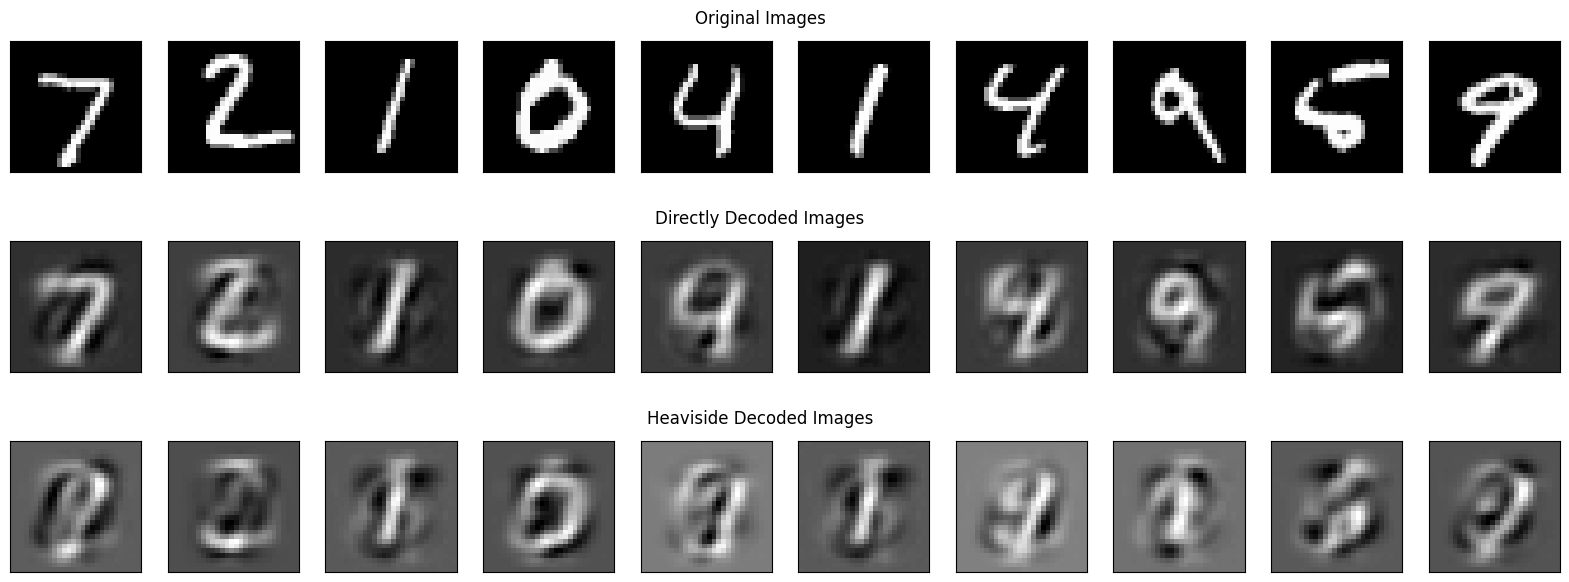

In [15]:
# ---------- ORIGINAL AND RECONSTRUCTED IMAGES ----------

n = 10
imsize = 2
fig = plt.figure(figsize=(n*imsize, 3*imsize))
subfigs = fig.subfigures(nrows=3, ncols=1)

for targetSubFig, imgs, title in zip(
    subfigs,
    [x_test, decodedImages, heavisideDecodedImages],
    ["Original Images", "Directly Decoded Images", "Heaviside Decoded Images"]
):
    targetSubFig.suptitle(title, y=0.98)
    axes = targetSubFig.subplots(nrows=1, ncols=n)
    for img, ax in zip(imgs, np.ravel(axes)):
        ax.imshow(img, cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# plt.tight_layout()
plt.show()

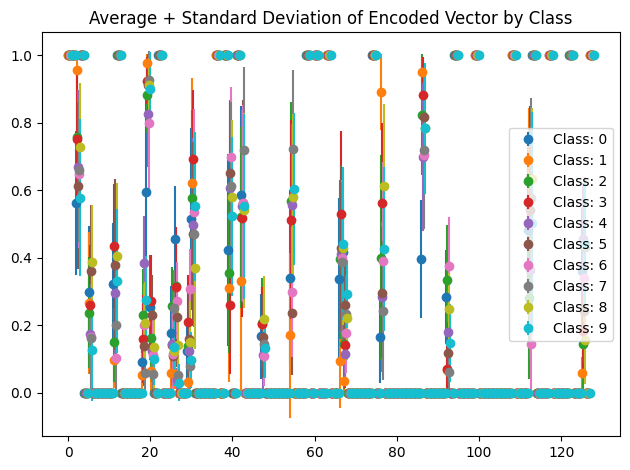

In [16]:
# ---------- AVERAGE ENCODED VEC BY CLASS ----------

cmap = mpl.colormaps["tab10"]
classOffset = 0.1
for classLabel in TARGET_CLASSES:
    classIndicesMask = y_test==classLabel
    classEncodedVecs = encodedVectors[classIndicesMask]
    averageEncodedVec = np.average(classEncodedVecs, axis=0)
    stdEncodedVec = np.std(classEncodedVecs, axis=0)
    # plt.plot(averageEncodedVec, label=f"Class: {classLabel}")
    plt.errorbar(np.arange(LATENT_DIMENSION)+classLabel*classOffset, averageEncodedVec, stdEncodedVec, fmt="o", color=cmap(classLabel), ecolor=cmap(classLabel), label=f"Class: {classLabel}")
plt.title(f"Average + Standard Deviation of Encoded Vector by Class")
plt.legend()
plt.tight_layout()
plt.show()

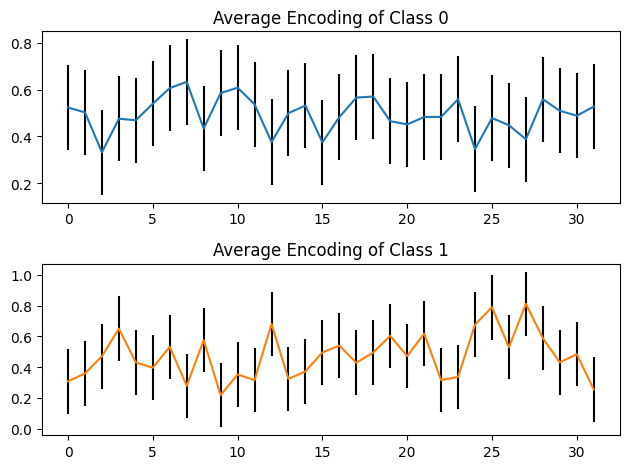

In [87]:
# ---------- ERRORBAR OF EACH CLASS ----------

fig, axes = plt.subplots(len(TARGET_CLASSES), 1)
for classLabel, ax in zip(TARGET_CLASSES, np.ravel(axes)):
    classIndicesMask = y_test==classLabel
    classEncodedVecs = encodedVectors[classIndicesMask]
    ax.errorbar(np.arange(LATENT_DIMENSION), np.average(classEncodedVecs, axis=0), np.std(classEncodedVecs), color=cmap(classLabel), ecolor="k")
    ax.set_title(f"Average Encoding of Class {classLabel}")
plt.tight_layout()
plt.show()  

PCA COMPONENT VARIANCES: [0.13762483 0.11347691 0.10672895 0.10429235 0.0787032  0.07546283
 0.06724222 0.06099546 0.0520992  0.04503876 0.03853601 0.03316911
 0.02257875 0.01522003 0.01469163 0.01066464]
PCA COMPONENT TOTAL VARIANCE: 0.9765248838293363


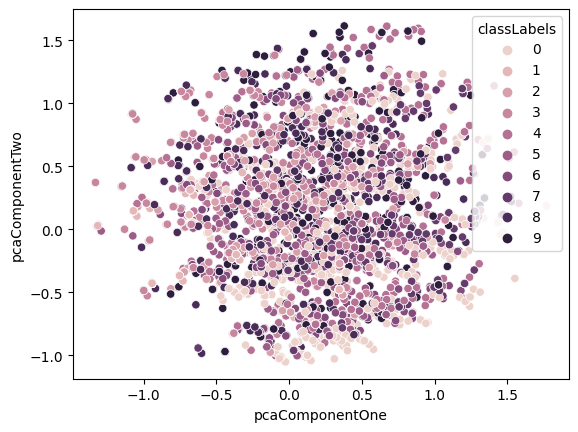

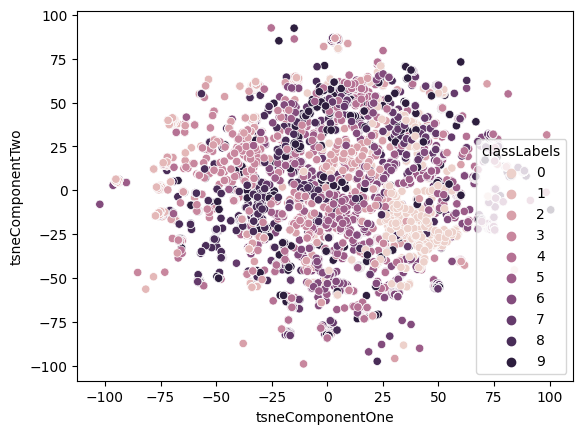

In [17]:
# ---------- PCA OF ENCODED VEC ----------
pca= PCA(n_components=16)
pcaResults = pca.fit_transform(heavisideVectors)
pcaResults = pd.DataFrame({
    "classLabels": y_test,
    "pcaComponentOne": pcaResults[:,0],
    "pcaComponentTwo": pcaResults[:,1],
})
print(f"PCA COMPONENT VARIANCES: {pca.explained_variance_ratio_}")
print(f"PCA COMPONENT TOTAL VARIANCE: {np.sum(pca.explained_variance_ratio_)}")
sns.scatterplot(pcaResults, x="pcaComponentOne", y="pcaComponentTwo", hue="classLabels", legend="full")
plt.show()


# ---------- TSNE OF ENCODED VEC ----------
tsne= TSNE(n_components=2)
tsneResults = tsne.fit_transform(heavisideVectors)
tsneResults = pd.DataFrame({
    "classLabels": y_test,
    "tsneComponentOne": tsneResults[:,0],
    "tsneComponentTwo": tsneResults[:,1],
})
sns.scatterplot(tsneResults, x="tsneComponentOne", y="tsneComponentTwo", hue="classLabels", legend="full")
plt.show()

In [18]:
binaryHeaviside = hmcalisterHopfieldUtils.hopfield.binaryHeaviside
bipolarHeaviside = hmcalisterHopfieldUtils.hopfield.bipolarHeaviside

LATENT_DIMENSION = 128
encoderLossWeightings = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
# encoderLossWeightings = [0.0, 1.0]
models = [CreateAndTrainAutoencoder(encoderLossWeighting=x, 
                                    latentDimension=LATENT_DIMENSION, 
                                    hiddenLayerShapes=[128,64],
                                    savePath=f"modelSaves/model{x}.keras",
                                    loadModel=False,
                                    verbose=1) for x in encoderLossWeightings]

Model: "auto_encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (1, 128)                  117056    
                                                                 
 decoder (Sequential)        (1, 28, 28)               117712    
                                                                 
Total params: 234,768
Trainable params: 234,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2023-11-16 13:58:21.894253: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 9s 4ms/step - loss: 0.0262 - decoderOutput_loss: 0.0262 - encoderOutput_loss: 0.4020 - val_loss: 0.0179 - val_decoderOutput_loss: 0.0179 - val_encoderOutput_loss: 0.4162
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0167 - decoderOutput_loss: 0.0167 - encoderOutput_loss: 0.4240 - val_loss: 0.0153 - val_decoderOutput_loss: 0.0153 - val_encoderOutput_loss: 0.4290
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0151 - decoderOutput_loss: 0.0151 - encoderOutput_loss: 0.4333 - val_loss: 0.0142 - val_decoderOutput_loss: 0.0142 - val_encoderOutput_loss: 0.4367
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0141 - decoderOutput_loss: 0.0141 - encoderOutput_loss: 0.4385 - val_loss: 0.0136 - val_decoderOutput_loss: 0.0136 - val_encoderOutput_loss: 0.4387
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0136 - decoderOutput_loss: 0.

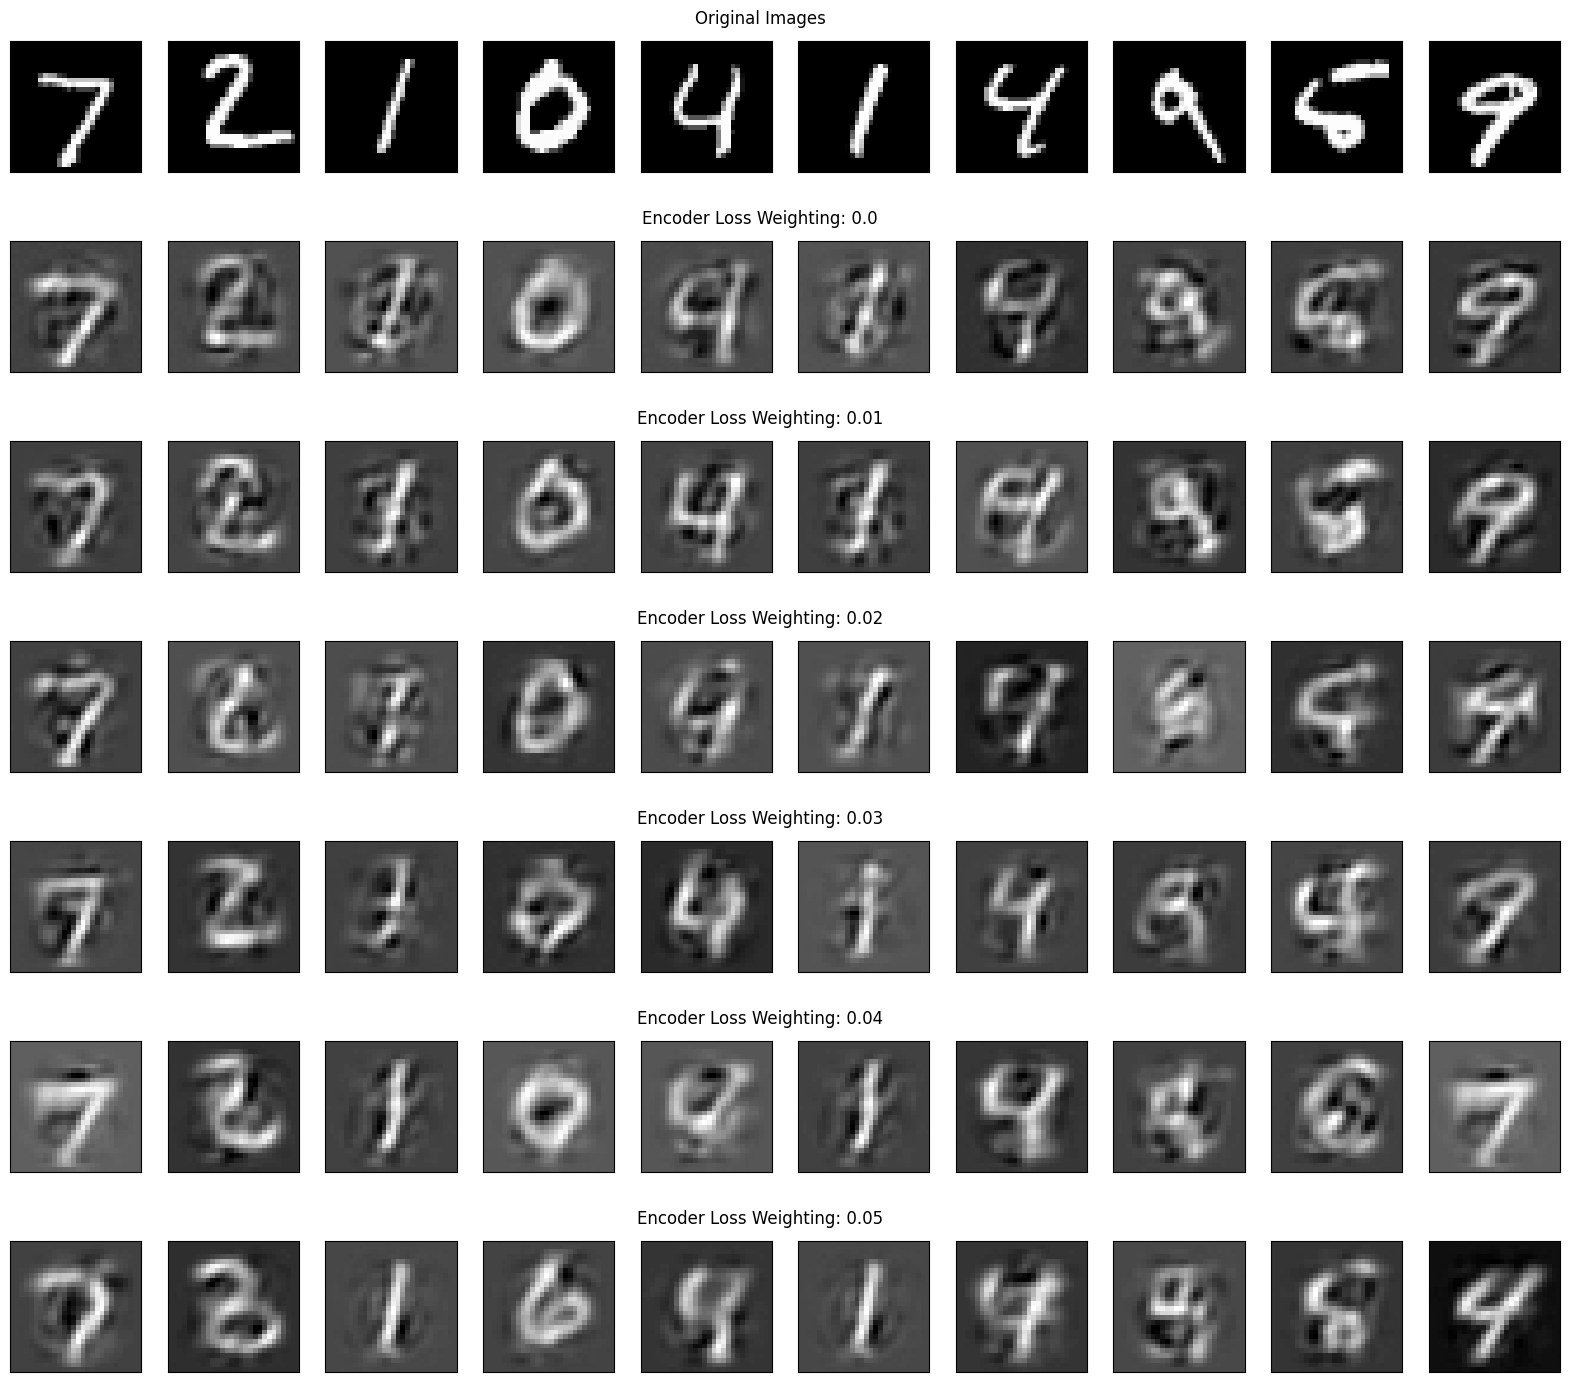

In [19]:
encodedVectorsByModel = []
directlyDecodedByModel = []
heavisideVectorsByModel = []
heavisideDecodedImagesByModel = []
for modelIndex in range(len(models)):
    model = models[modelIndex]
    encodedVectors = model.encoderNetwork(x_test).numpy()
    directlyDecodedImgs = model.decoderNetwork(encodedVectors).numpy()
    heavisideVectors = binaryHeaviside(encodedVectors-0.5)
    heavisideDecodedImages = model.decoderNetwork(heavisideVectors).numpy()

    encodedVectorsByModel.append(encodedVectors)
    directlyDecodedByModel.append(directlyDecodedImgs)
    heavisideVectorsByModel.append(heavisideVectors)
    heavisideDecodedImagesByModel.append(heavisideDecodedImages)

# ---------- ORIGINAL AND RECONSTRUCTED IMAGES ----------

numImages = 10
imsize = 2
fig = plt.figure(figsize=(numImages*imsize, (1+len(models))*imsize))
subfigs = fig.subfigures(nrows=(1+len(models)), ncols=1)


subfigs[0].suptitle("Original Images")
axes = subfigs[0].subplots(nrows=1, ncols=numImages)
for img, ax in zip(x_test, np.ravel(axes)):
    ax.imshow(img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for targetSubFig, imgs, encoderLosses in zip(
    subfigs[1:],
    heavisideDecodedImagesByModel,
    encoderLossWeightings
):
    targetSubFig.suptitle(f"Encoder Loss Weighting: {encoderLosses}", y=0.98)
    axes = targetSubFig.subplots(nrows=1, ncols=numImages)
    for img, ax in zip(imgs, np.ravel(axes)):
        ax.imshow(img, cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# plt.tight_layout()
plt.show()